# Implicit method for the advection-dispersion problem

# Example 13.1 BTCS method

In [117]:
import numpy as np
import matplotlib.pyplot as plt

In [118]:
H = 1  # water depth, m
W = 60 # width, m

U = 2400 # velocity, m/hr
Q = 144000 # discharge, m^3/hr
E = 150000 # dispersion m^2/hr
Ac = 60 # cross section area, m^2
M = 5 # spill mass, kg
x0 = 500 # spill location, m

In [119]:
def BTCS(xend, tend, dt, dx):
    # calculate numerical dispersion
    En = U**2*dt/2
    # remove numerical dispersion
    Em = E-En

    # define location of numerical simulation
    xrange = np.arange(0,xend,dx)
    nx = len(xrange)
    

    # define initial concentratio
    c0 = np.zeros(nx)
    c0[np.abs(xrange-x0) == min(np.abs(xrange-x0))] = M*1e3/(Ac*dx)        
    # There is no loading after the initial spill
    W = np.zeros(nx)


    Ep = Em * Ac / dx

    t = 0
    c_old = c0
    c_new = c0

    a1 = U*dt/(2*dx)
    b1 = Ep*dt/(dx**2)

    while t < tend:
        A = np.zeros((nx,nx))
        A[0,0] = 1
        A[-1,-1] = 1
        for i in range(1,nx-1):
            A[i,i-1:i+2] = [-a1-b1, 1+2*b1, a1-b1]
        RHS = c_old + W*dt/(dx*Ac)
        c_new = np.dot(np.linalg.inv(A), RHS)

        # update time and update concentration for next step
        t = t + dt
        c_old = c_new
 
    return c_new, xrange

Text(0.5, 0, 'x (m)')

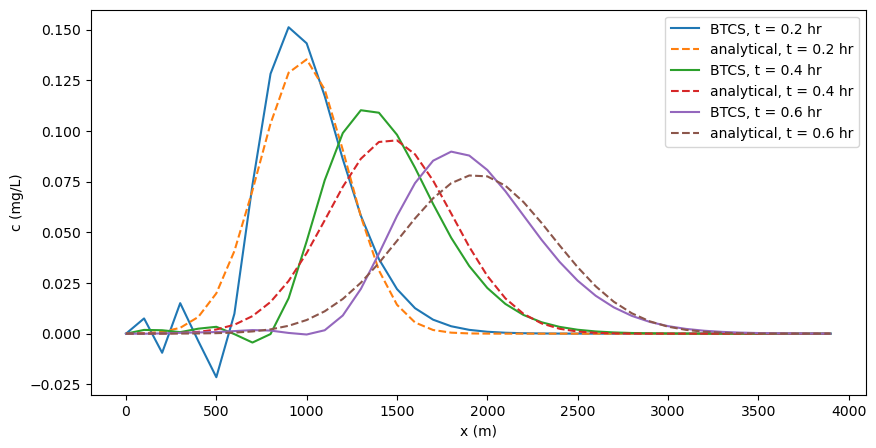

In [120]:
tend = np.array([0.2, 0.4, 0.6])

plt.figure(figsize=(10,5))
for ti in tend:
    c, x = BTCS(4000, ti, 0.025, 100)
    c_analytical = M*1000/Ac/np.sqrt(4*np.pi*E*ti) * np.exp(-(x-x0-U*ti)**2/(4*E*ti))
    plt.plot(x,c,label='BTCS, t = ' + str(ti)+ ' hr')
    plt.plot(x,c_analytical,'--', label = 'analytical, t = ' + str(ti) + ' hr')
plt.legend() 
plt.ylabel('c (mg/L)')
plt.xlabel('x (m)') 

From the above example, we found that the backward-time algorithm does not have a stability issue. However, the accuracy is not satisfactory. 

## Crank-Nicolson method (no numerical dispersion should be considered)

In [121]:
def CN(xend, tend, dt, dx):
    
    # define location of numerical simulation
    xrange = np.arange(0,xend,dx)
    nx = len(xrange)
    

    # define initial concentratio
    c0 = np.zeros(nx)
    c0[np.abs(xrange-x0) == min(np.abs(xrange-x0))] = M*1e3/(Ac*dx)        
    # There is no loading after the initial spill
    W = np.zeros(nx)


    Ep = E * Ac / dx

    t = 0
    c_old = c0
    c_new = c0

    a1 = U*dt/(2*dx)
    b1 = E*dt/(dx**2)

    while t < tend:
        A = np.zeros((nx,nx))
        A[0,0] = 1
        A[-1,-1] = 1
        RHS = np.zeros(nx)
        for i in range(1,nx-1):
            A[i,i-1:i+2] = [-a1-b1, 2+2*b1, a1-b1]
            RHS[i] = (a1+b1)*c_old[i-1] + (2-2*b1)*c_old[i] + (b1-a1)*c_old[i+1]
        c_new = np.dot(np.linalg.inv(A), RHS)

        # update time and update concentration for next step
        t = t + dt
        c_old = c_new
 
    return c_new, xrange

Text(0.5, 0, 'x (m)')

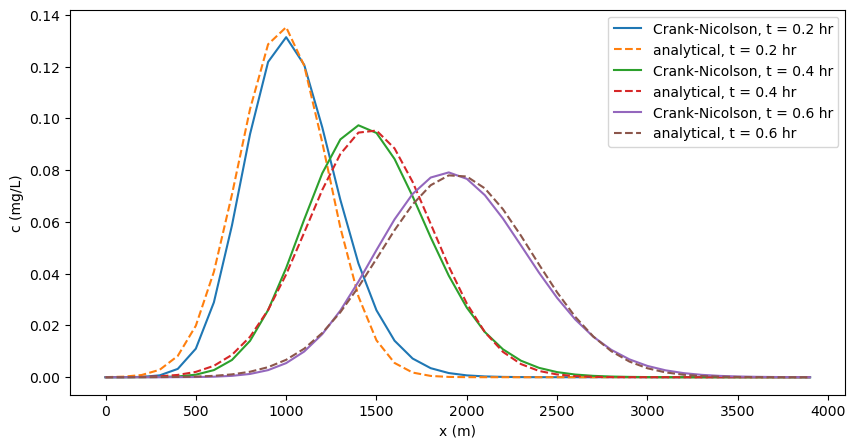

In [122]:
tend = np.array([0.2, 0.4, 0.6])

plt.figure(figsize=(10,5))
for ti in tend:
    c, x = CN(4000, ti, 0.025, 100)
    c_analytical = M*1000/Ac/np.sqrt(4*np.pi*E*ti) * np.exp(-(x-x0-U*ti)**2/(4*E*ti))
    plt.plot(x,c,label='Crank-Nicolson, t = ' + str(ti)+ ' hr')
    plt.plot(x,c_analytical,'--', label = 'analytical, t = ' + str(ti) + ' hr')
plt.legend() 
plt.ylabel('c (mg/L)')
plt.xlabel('x (m)') 

# MacCormack method (1969) - Explicit predictor-corrector method

In [128]:
def MacCormack(xend, tend, dt, dx):
    
    # define location of numerical simulation
    xrange = np.arange(0,xend,dx)
    # initial concentration at the spill
    c_spill = M/(Ac*dx)*1000 # kg/m^3 --> mg/L
    # define initial concentration, assign c_spill to the location of the spill
    c0 = np.zeros(len(xrange))
    c0[np.abs(xrange-x0) == min(np.abs(xrange-x0))] = c_spill
    
    t = 0
    c_old = c0
    c_new = c0
    
    s1 = np.zeros(len(xrange))
    s2 = np.zeros(len(xrange))
    while t < tend:
        s1[1:-1] = -U/dx * (c_old[2:] - c_old[1:-1]) + E/(dx**2) * (c_old[2:]-2*c_old[1:-1]+c_old[:-2])
        c_predictor = c_old + s1*dt
        
        s2[1:-1] = -U/dx * (c_predictor[1:-1] - c_predictor[:-2]) + E/(dx**2) * (c_predictor[2:]-2*c_predictor[1:-1]+c_predictor[:-2])
        
        c_new[1:-1] = c_old[1:-1] + (s1[1:-1]+s2[1:-1])/2 * dt
        # we should select a far upstream and downstream where the concentration is zero
        c_new[0] = 0
        c_new[-1] = 0
        
        # update time and update concentration for next step
        t = t+dt
        c_old = c_new
        
    return c_new, xrange

Text(0.5, 0, 'x (m)')

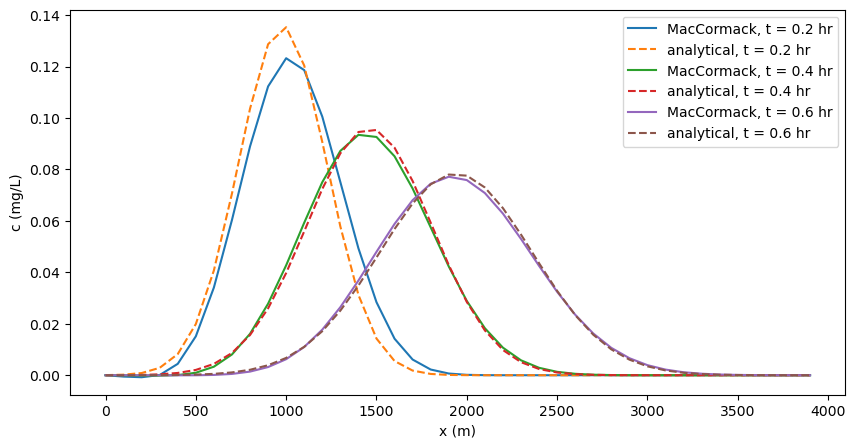

In [130]:
tend = np.array([0.2, 0.4, 0.6])

plt.figure(figsize=(10,5))
for ti in tend:
    c, x = MacCormack(4000, ti, 0.025, 100)
    c_analytical = M*1000/Ac/np.sqrt(4*np.pi*E*ti) * np.exp(-(x-x0-U*ti)**2/(4*E*ti))
    plt.plot(x,c,label='MacCormack, t = ' + str(ti)+ ' hr')
    plt.plot(x,c_analytical,'--', label = 'analytical, t = ' + str(ti) + ' hr')
plt.legend() 
plt.ylabel('c (mg/L)')
plt.xlabel('x (m)') 

The above example shows that the MacCormack method is explicit, easy to code, and are okay with the stability, although this method is still conditional stable. 